<a href="https://colab.research.google.com/github/Deepanjali01/AI-ML-1/blob/main/Spotify%20Recommendation/Spotify%20Playlist%20Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook shows the steps to build a recommender system using the Collaborative Filtering approach.

### The goal is to recommend artists based on user's past activity and interests of similar users.

* [Import Libraries ](#section-1)
* [Read Data](#section-2)
* [Data Prep](#section-3)
* [Recommender System](#section-4)
    - [Helper Functions](#subsection-1)
    - [Prep Model Inputs](#subsection-2)
    - [Matrix Factorization (MF) Model](#subsection-3)
    - [Evaluation Metrics](#subsection-4)
    - [Examples](#subsection-5)

<a id="section-1"></a>
# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy import sparse
import random
import lightfm
from lightfm import LightFM, cross_validation
from lightfm.evaluation import precision_at_k, auc_score
from sklearn.metrics.pairwise import cosine_similarity

<a id="section-2"></a>
# Read Data

### The original dataset is quite large. We only read 50% of rows for faster run.

In [ ]:
p = 0.50  # to randomly select 50% of the rows

In [ ]:
df_playlist = pd.read_csv('/kaggle/input/spotify-playlists/spotify_dataset.csv', error_bad_lines=False, warn_bad_lines=False, skiprows=lambda i: i>0 and random.random() > p)
df_playlist.head()

,user_id,"""artistname""","""trackname""","""playlistname"""
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Joe Echo,Beautiful,HARD ROCK 2010


### Size of dataframe

In [ ]:
df_playlist.shape

(6445351, 4)

### Clean up column names

In [ ]:
df_playlist.columns = df_playlist.columns.str.replace('"', '')
df_playlist.columns = df_playlist.columns.str.replace('name', '')
df_playlist.columns = df_playlist.columns.str.replace(' ', '')
df_playlist.columns

Index(['user_id', 'artist', 'track', 'playlist'], dtype='object')

In [ ]:
# CHECKING FOR MISSING VALUES
df_playlist.isnull().sum()

In [ ]:
#DROPPING MISSING VALUES
df_playlist.dropna(axis = 0, inplace = True, subset = ['first_review','host_response_rate','last_review','neighbourhood','host_has_profile_pic','host_identity_verified','host_since','thumbnail_url','zipcode'])

In [ ]:
#REPLACING MISSING VALUES WITH MEAN
df_playlist['bathrooms'] = df_playlist['bathrooms'].fillna(df_playlist['bathrooms'].mean())
df_playlist['review_scores_rating'] = df_playlist['review_scores_rating'].fillna(df_playlist['review_scores_rating'].mean())
df_playlist['bedrooms'] = df_playlist['bedrooms'].fillna(df_playlist['bedrooms'].mean())
df_playlist['beds'] = df_playlist['beds'].fillna(df_playlist['beds'].mean())

<a id="section-3"></a>
# Data Prep

#### For recommender system, We are only keeping the artists with frequency higher than 50

In [ ]:
df_playlist = df_playlist.groupby('artist').filter(lambda x : len(x)>=50)

#### And keeping the users with at least 10 unique artists in their playlists to lessen the impact of cold start problem

In [ ]:
df_playlist = df_playlist[df_playlist.groupby('user_id').artist.transform('nunique') >= 10]

#### Group by to get the frequnecy count for each user and artist (# of times that an artist has appeared in playlists created by a user)

In [ ]:
size = lambda x: len(x)
df_freq = df_playlist.groupby(['user_id', 'artist']).agg('size').reset_index().rename(columns={0:'freq'})[['user_id', 'artist', 'freq']].sort_values(['freq'], ascending=False)
df_freq.head()

,user_id,artist,freq
1392476,defced0ece4ce946160b0d2698142eac,Vitamin String Quartet,1677
246434,26b51e580277e131f87e4c7ee4c0887a,Vitamin String Quartet,1667
411753,414050deadb38aafd8d4ad22ca634055,Vitamin String Quartet,1295
1357893,d993ff8f2de226e2c6803e47a22e9d7e,Lata Mangeshkar,1152
10913,014e695cc6df96011b90a5beb3206012,Ilaiyaraaja,1091


### create a DF for artists and add artist id

In [ ]:
df_artist = pd.DataFrame(df_freq["artist"].unique())
df_artist = df_artist.reset_index()
df_artist = df_artist.rename(columns={'index':'artist_id', 0:'artist'})
df_artist.head()

,artist_id,artist
0,0,Vitamin String Quartet
1,1,Lata Mangeshkar
2,2,Ilaiyaraaja
3,3,Peggy Lee
4,4,Grateful Dead


In [ ]:
df_artist.shape

(14307, 2)

### add artist_id to the main DF

In [ ]:
df_freq  = pd.merge(df_freq , df_artist, how='inner', on='artist')

<a id="section-4"></a>
# Recommender System

#### We are using the LightFM library and run a traditional MF model since the dataset doesn't include any user or artist features,


<a id="subsection-1"></a>
## Helper Functions

In [ ]:
def create_interaction_matrix(df,user_col, item_col, rating_col, norm= False, threshold = None):
    '''
    Function to create an interaction matrix dataframe from transactional type interactions
    Required Input -
        - df = Pandas DataFrame containing user-item interactions
        - user_col = column name containing user's identifier
        - item_col = column name containing item's identifier
        - rating col = column name containing user feedback on interaction with a given item
        - norm (optional) = True if a normalization of ratings is needed
        - threshold (required if norm = True) = value above which the rating is favorable
    Expected output -
        - Pandas dataframe with user-item interactions ready to be fed in a recommendation algorithm
    '''
    interactions = df.groupby([user_col, item_col])[rating_col] \
            .sum().unstack().reset_index(). \
            fillna(0).set_index(user_col)
    if norm:
        interactions = interactions.applymap(lambda x: 1 if x > threshold else 0)
    return interactions

In [ ]:
def create_user_dict(interactions):
    '''
    Function to create a user dictionary based on their index and number in interaction dataset
    Required Input -
        interactions - dataset create by create_interaction_matrix
    Expected Output -
        user_dict - Dictionary type output containing interaction_index as key and user_id as value
    '''
    user_id = list(interactions.index)
    user_dict = {}
    counter = 0
    for i in user_id:
        user_dict[i] = counter
        counter += 1
    return user_dict

In [ ]:
def create_item_dict(df,id_col,name_col):
    '''
    Function to create an item dictionary based on their item_id and item name
    Required Input -
        - df = Pandas dataframe with Item information
        - id_col = Column name containing unique identifier for an item
        - name_col = Column name containing name of the item
    Expected Output -
        item_dict = Dictionary type output containing item_id as key and item_name as value
    '''
    item_dict ={}
    for i in range(df.shape[0]):
        item_dict[(df.loc[i,id_col])] = df.loc[i,name_col]
    return item_dict

In [ ]:
def runMF(interactions, n_components=30, loss='warp', k=15, epoch=30,n_jobs = 4):
    '''
    Function to run matrix-factorization algorithm
    Required Input -
        - interactions = dataset create by create_interaction_matrix
        - n_components = number of embeddings you want to create to define Item and user
        - loss = loss function other options are logistic, brp
        - epoch = number of epochs to run
        - n_jobs = number of cores used for execution
    Expected Output  -
        Model - Trained model
    '''

    #uncommented for train test split
#     x = sparse.csr_matrix(interactions.values)
    model = LightFM(no_components= n_components, loss=loss,k=k)
    model.fit(x,epochs=epoch,num_threads = n_jobs)
    return model

In [ ]:
def sample_recommendation_user(model, interactions, user_id, user_dict,
                               item_dict,threshold = 0,nrec_items = 10, show = True):
    '''
    Function to produce user recommendations
    Required Input -
        - model = Trained matrix factorization model
        - interactions = dataset used for training the model
        - user_id = user ID for which we need to generate recommendation
        - user_dict = Dictionary type input containing interaction_index as key and user_id as value
        - item_dict = Dictionary type input containing item_id as key and item_name as value
        - threshold = value above which the rating is favorable in new interaction matrix
        - nrec_items = Number of output recommendation needed
    Expected Output -
        - Prints list of items the given user has already bought
        - Prints list of N recommended items  which user hopefully will be interested in
    '''
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))

    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index) \
								 .sort_values(ascending=False))

    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    if show == True:
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1

        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1
    return return_score_list

<a id="subsection-2"></a>
## Prep Model Inputs

### Create interaction matrix

In [ ]:
interactions = create_interaction_matrix(df = df_freq, user_col = "user_id", item_col = 'artist_id', rating_col = 'freq', norm= False, threshold = None)
interactions.head()

artist_id,0,1,2,3,4,5,6,7,8,9,...,14297,14298,14299,14300,14301,14302,14303,14304,14305,14306
user_id,,,,,,,,,,,,,,,,,,,,,
00055176fea33f6e027cd3302289378b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0007f3dd09c91198371454c608d47f22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000b0f32b5739f052b9d40fcc5c41079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000c11a16c89aa4b14b328080f5954ee,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00123e0f544dee3ab006aa7f1e5725a7,0.0,0.0,0.0,0.0,16.0,1.0,0.0,72.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
interactions.shape

(12925, 14307)

### Create User Dict

In [ ]:
user_dict = create_user_dict(interactions=interactions)

### Create Item dict

In [ ]:
artists_dict = create_item_dict(df = df_artist, id_col = 'artist_id', name_col = 'artist')

### Train-Test split

In [ ]:
x = sparse.csr_matrix(interactions.values)
train, test = lightfm.cross_validation.random_train_test_split(x, test_percentage=0.2, random_state=None)

<a id="subsection-3"></a>
## Matrix Factorization (MF) Model

### Train the Matrix Factorization Model

In [ ]:
%time
model = runMF(interactions = train,
                 n_components = 30,
                 loss = 'warp',
                 k = 15,
                 epoch = 30,
                 n_jobs = 4)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.39 µs


#### We can do hyper-parameter tuning for better results

<a id="subsection-4"></a>
## Evaluation Metrics

 ### Compute AUC score for Train set

In [ ]:
train_auc = auc_score(model, train, num_threads=4).mean()
print('Train AUC: %s' % train_auc)

Train AUC: 0.9668088


### Compute AUC score for Test set

#### The parameter train_interactions allows us to exclude known positives in training set from the predicitons and score calculations.
#### This is to avoid re-recommending the items the user has alreardy interacted with

In [ ]:
test_auc = auc_score(model, test, train_interactions=train, num_threads=4).mean()
print('Test AUC: %s' % test_auc)

Test AUC: 0.967546


### Compute Precision scores
#### Precision score is based on the number of positives items in the K highest ranked items.

In [ ]:
train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()

In [ ]:
print('train Precision %.2f, test Precision %.2f.' % (train_precision, test_precision))

train Precision 0.40, test Precision 0.19.


<a id="subsection-5"></a>
## Examples

### Let's see some examples of recommendations:

In [ ]:
rec_list = sample_recommendation_user(model = model,
                                      interactions = interactions,
                                      user_id = '9cc0cfd4d7d7885102480dd99e7a90d6',
                                      user_dict = user_dict,
                                      item_dict = artists_dict,
                                      threshold = 0,
                                      nrec_items = 10,
                                      show = True)

Known Likes:
1- Miles Kane
2- Crosby, Stills & Nash
3- Lissie
4- Noel Gallagher's High Flying Birds
5- Noah And The Whale
6- Tom Petty
7- Joshua Radin
8- Crowded House
9- Elbow
10- Biffy Clyro
11- Madness
12- Tom Petty And The Heartbreakers
13- Oasis
14- Elvis Costello
15- Elvis Costello & The Attractions
16- Pearl Jam
17- Paul McCartney
18- Bruce Springsteen

 Recommended Items:
1- U2
2- The Rolling Stones
3- Radiohead
4- David Bowie
5- Bob Dylan
6- The Cure
7- R.E.M.
8- Coldplay
9- Kings Of Leon
10- Johnny Cash


In [ ]:
rec_list = sample_recommendation_user(model = model,
                                      interactions = interactions,
                                      user_id = 'ffe32d5412269f3041c58cbf0dde3306',
                                      user_dict = user_dict,
                                      item_dict = artists_dict,
                                      threshold = 0,
                                      nrec_items = 10,
                                      show = True)

Known Likes:
1- McFadden & Whitehead
2- The Whispers
3- Sheila E.
4- Tony! Toni! Toné!
5- Bill Withers
6- The Damnwells
7- CHVRCHES
8- Delta Spirit
9- The Impressions
10- The Heavy
11- The New Pornographers
12- Maze
13- Neko Case
14- Jackson 5
15- The National
16- REO Speedwagon
17- Otis Redding
18- Michael Jackson
19- Radiohead
20- Earth, Wind & Fire
21- Stevie Wonder
22- Bruce Springsteen
23- Aretha Franklin
24- Ray Charles

 Recommended Items:
1- Prince
2- Fleetwood Mac
3- Marvin Gaye
4- Talking Heads
5- Al Green
6- James Brown
7- Daryl Hall & John Oates
8- David Bowie
9- Paul Simon
10- Alabama Shakes


Analysis and Visualization Tasks

In [ ]:
#TODO Create a histogram showing the distribution of the number of tracks added by each user.
import matplotlib.pyplot as plt
track_counts = df_playlist.groupby('user_id').size()
print(track_counts.describe())  # Check the statistical summary

In [ ]:
#plotting a histogram with original data
plt.figure(figsize=(10,10))
plt.hist(track_counts, bins=50, color='skyblue')
max_tracks = track_counts.max()
plt.title('Distribution of Number of Tracks Added by Each User')
plt.xlabel('Number of Tracks')
plt.ylabel('Number of Users')
plt.show()

In [ ]:
#this graph shows that the data is skewed and thus we need to scale it thus used logarithmic scaling
log_data = np.log10(track_counts)

# Plot the histogram of the transformed data
plt.figure(figsize=(12, 6))
plt.hist(log_data, bins=50, color='skyblue', alpha=0.8)

# Customize labels and title
plt.title('Log-Transformed Histogram of Number of Tracks Added by Users')
plt.xlabel('Log10(Number of Tracks)')
plt.ylabel('Frequency')

# Add gridlines for better readability
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()

In [ ]:
#TODO Create a bar plot showing the top 10 most popular artists based on the number of times they appear in playlists.

import matplotlib as plt

artist_counts = df_playlist['artistname'].value_counts()

# Get the top 10 artists
top_artists = artist_counts.head(10)

# Plot the data
plt.figure(figsize=(10, 6))
top_artists.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Top 10 Most Popular Artists Based on Playlist Appearances', fontsize=14)
plt.xlabel('Artist Name', fontsize=12)
plt.ylabel('Number of Appearances', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
#TODO Create a bar plot showing the top 10 most popular tracks based on frequency in playlists.

track_counts = df_playlist['trackname'].value_counts()

# Get the top 10 tracks
top_tracks = track_counts.head(10)

# Plot the data
plt.figure(figsize=(10, 6))
top_tracks.plot(kind='bar', color='orange', edgecolor='black')

plt.title('Top 10 Most Popular Tracks Based on Playlist Appearances', fontsize=14)
plt.xlabel('Track Name', fontsize=12)
plt.ylabel('Number of Appearances', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

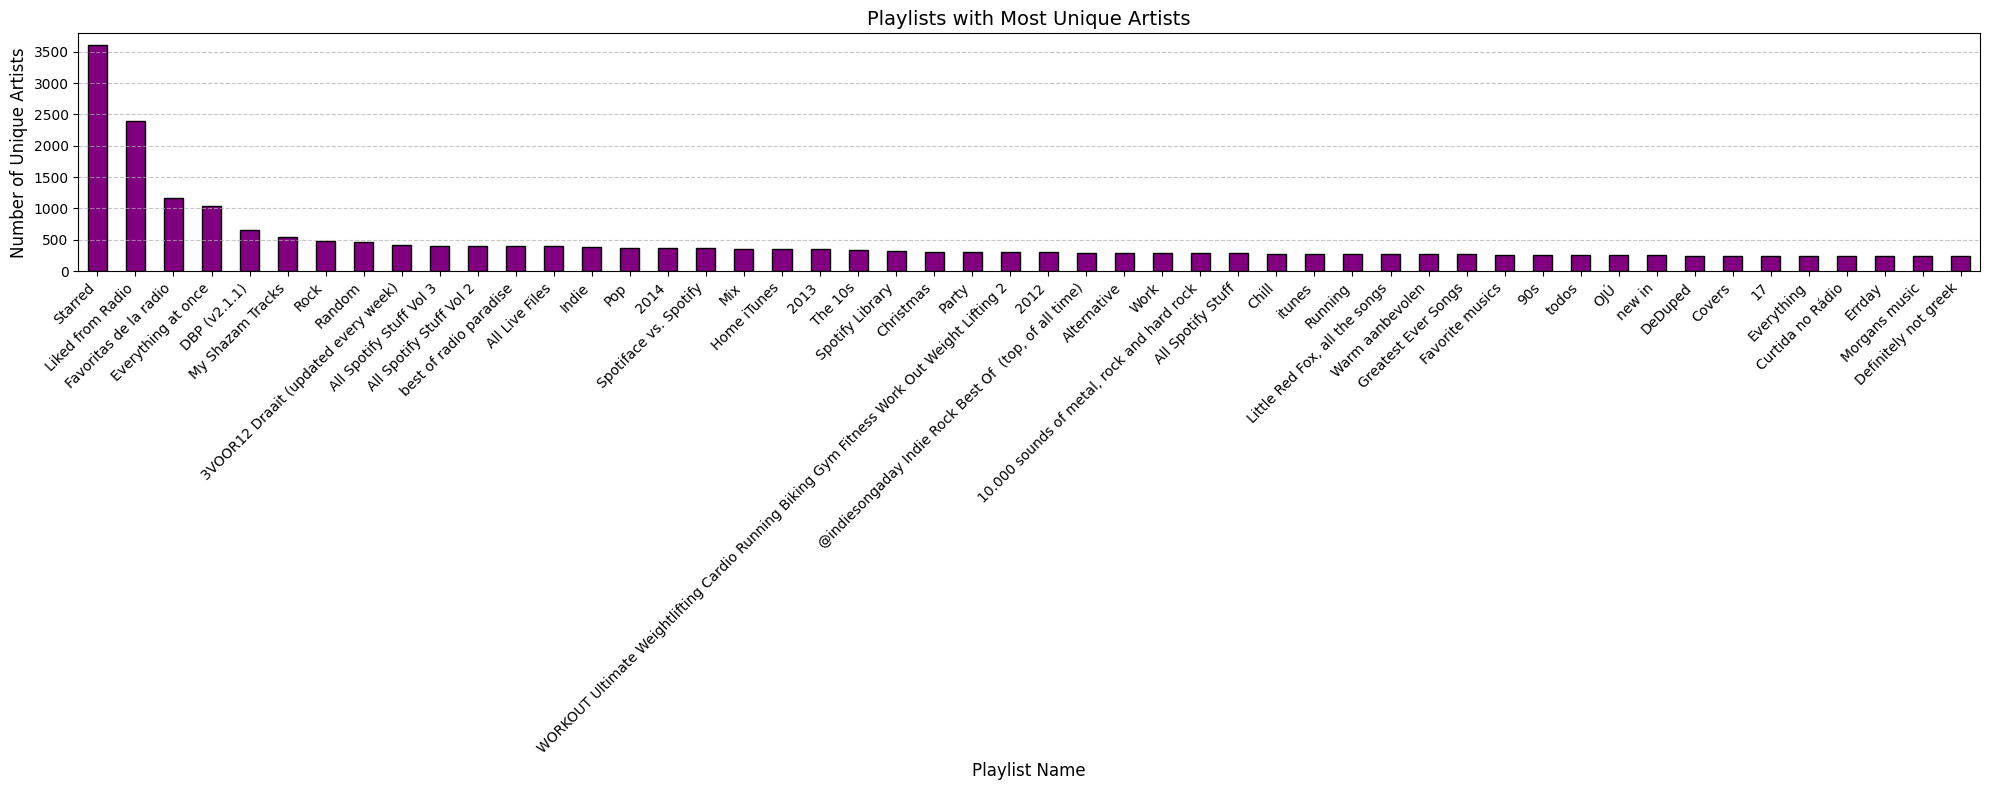

In [83]:
#TODO Create a visualization showing the number of unique artists in each playlist.
import matplotlib.pyplot as plt

# Count unique artists per playlist
unique_artists_per_playlist = df_playlist.groupby('playlist')['artist'].nunique()

# Plot the data
plt.figure(figsize=(20, 8))
unique_artists_per_playlist.sort_values(ascending=False).head(50).plot(kind='bar', color='purple', edgecolor='black')

plt.title('Playlists with Most Unique Artists', fontsize=14)
plt.xlabel('Playlist Name', fontsize=12)
plt.ylabel('Number of Unique Artists', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
#TODO Create a heatmap or pivot table showing the relationship between playlists and their most commonly added tracks.

In [ ]:
#TODO Display a summary of the dataset, including total users, artists, tracks, and playlists.

In [ ]:
#TODO Display a summary of the dataset, including total users, artists, tracks, and playlists.

In [ ]:
#TODO Check for and handle missing values in the dataset.

In [ ]:
#TODO Add a markdown cell explaining collaborative filtering concepts in simple terms with examples.

In [ ]:
#TODO Compare multiple evaluation metrics (e.g., precision, recall, and F1-score) in a single table or plot.